# Toy example

This notebook shows how to use the toolkit for explainable AI and fairness. The toy example used is a binary classification trained using lightGBM.

The toolkit uses part, if not all, of the following open-source Python packages:
- `pdpbox`
- `shap`
- `aif360`

The toolkit is model agnostic; the selected functions of the packages should work for models trained by most algorithms.

In [1]:
import json

import numpy as np
import pandas as pd
import lightgbm as lgb
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder, OneHotEncoder

import shap
# shap.initjs()

from utils import compute_log_metrics, plot_roc_curve, plot_pr_curve

%matplotlib inline
%load_ext autoreload
%autoreload 2

sns.set()
sns.set_color_codes("muted")
pd.options.display.max_columns = 30

/home/kokmeng/anaconda3/envs/tf15/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Load data, category_map

In [2]:
NUMERIC_FEATS = [
    'Age',
    'Capital Gain',
    'Capital Loss',
    'Hours per week',
]

CATEGORICAL_FEATS = [
    'Workclass',
    'Education',
    'Marital Status',
    'Occupation',
    'Relationship',
    'Race',
    'Sex',
    'Country',
]

TARGET = "Target"
TARGET_NAMES = ['<=50K', '>50K']

category_map = json.load(open("input/category_map.txt"))
category_map

{'Workclass': ['Workclass=?',
  'Workclass=Federal-gov',
  'Workclass=Local-gov',
  'Workclass=Never-worked',
  'Workclass=Private',
  'Workclass=Self-emp-inc',
  'Workclass=Self-emp-not-inc',
  'Workclass=State-gov',
  'Workclass=Without-pay'],
 'Education': ['Education=Associates',
  'Education=Bachelors',
  'Education=Doctorate',
  'Education=Dropout',
  'Education=High School grad',
  'Education=Masters',
  'Education=Prof-School'],
 'Marital Status': ['Marital Status=Married',
  'Marital Status=Never-Married',
  'Marital Status=Separated',
  'Marital Status=Widowed'],
 'Occupation': ['Occupation=?',
  'Occupation=Admin',
  'Occupation=Blue-Collar',
  'Occupation=Military',
  'Occupation=Other',
  'Occupation=Professional',
  'Occupation=Sales',
  'Occupation=Service',
  'Occupation=White-Collar'],
 'Relationship': ['Relationship=Husband',
  'Relationship=Not-in-family',
  'Relationship=Other-relative',
  'Relationship=Own-child',
  'Relationship=Unmarried',
  'Relationship=Wife'],

In [3]:
data = pd.read_csv("input/adult.csv")
data = data[CATEGORICAL_FEATS + NUMERIC_FEATS + [TARGET]]
print(data.shape)
data.head()

(32561, 13)


,Workclass,Education,Marital Status,Occupation,Relationship,Race,Sex,Country,Age,Capital Gain,Capital Loss,Hours per week,Target
0,7,1,1,1,1,4,1,9,39,2174,0,40,0
1,6,1,0,8,0,4,1,9,50,0,0,13,0
2,4,4,2,2,1,4,1,9,38,0,0,40,0
3,4,3,0,2,0,2,1,9,53,0,0,40,0
4,4,1,0,5,5,2,0,6,28,0,0,40,0


In [41]:
# Split train and validation data
raw_train, raw_val = train_test_split(data, random_state=1)
y_train = raw_train[TARGET].values
y_val = raw_val[TARGET].values

## Preprocess

In [5]:
# Apply OHE to categorical features
categories = []
for f in CATEGORICAL_FEATS:
    categories.append(list(range(len(category_map[f]))))
    
ohe = OneHotEncoder(categories=categories, sparse=False)
ohe_train = ohe.fit_transform(raw_train[CATEGORICAL_FEATS])
ohe_val = ohe.transform(raw_val[CATEGORICAL_FEATS])

In [6]:
# Standardise numeric features to [-1, 1]
minmax_scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_train = minmax_scaler.fit_transform(raw_train[NUMERIC_FEATS])
scaled_val = minmax_scaler.fit_transform(raw_val[NUMERIC_FEATS])

In [7]:
# Concatenate data and set it as pandas.DataFrame.
# Required in order to use PDP and SHAP
OHE_CAT_FEATS = []
for f in CATEGORICAL_FEATS:
    OHE_CAT_FEATS.extend(category_map[f])

FEATURES = OHE_CAT_FEATS + NUMERIC_FEATS
    
x_train = pd.DataFrame(np.c_[ohe_train, scaled_train].astype(np.float32, copy=False),
                       columns=FEATURES)
x_val = pd.DataFrame(np.c_[ohe_val, scaled_val].astype(np.float32, copy=False),
                       columns=FEATURES)

## Train model

In [8]:
def lgb_roc_auc_score(y_true, y_pred):
    return "roc_auc", metrics.roc_auc_score(y_true, y_pred), True

In [9]:
# Train
clf = lgb.LGBMClassifier(
    learning_rate=0.1,
    num_leaves=20,
    n_estimators=100,
)

clf.fit(
    x_train, y_train,
    eval_set=[(x_val, y_val)],
    eval_metric=lgb_roc_auc_score,
    verbose=False,
)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=20, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

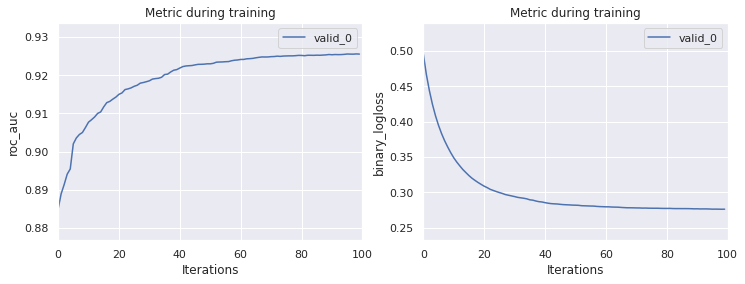

In [10]:
fig, axs = plt.subplots(1,2, figsize=(12,4))
lgb.plot_metric(clf, "roc_auc", ax=axs[0])
lgb.plot_metric(clf, "binary_logloss", ax=axs[1])
plt.show()

In [11]:
y_prob = clf.predict_proba(x_val)[:, 1]

compute_log_metrics(y_val, y_prob)

Accuracy = 0.877902
ROC AUC = 0.925541
Average precision = 0.811521


# Entry point of explainability tools

- We have written some wrapper functions in `utils.py` to plot partial dependence plots.
- We also demonstrate how to use `SHAP` in our toy example, which one can easily adapt it for their own use cases. SHAP is well maintained and easy to use. User can refer to the SHAP documentation for more details. 
- The requirements for using the toolkit are
  - sample data
  - model

## Sample data

This is to reduce the computation time. The more data is used, the longer the tools will need to process.

In [12]:
from toolkit import pdp_plot, actual_plot, target_plot, pdp_interact_plot

In [13]:
np.random.seed(0)
idx = np.random.choice(np.arange(len(x_train)), size=3000, replace=False)

x_sample = x_train.iloc[idx]

sample = x_sample.copy()
sample[TARGET] = y_train.iloc[idx].values

# Partial Dependence Plots

### 1D Partial Dependence Plots

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


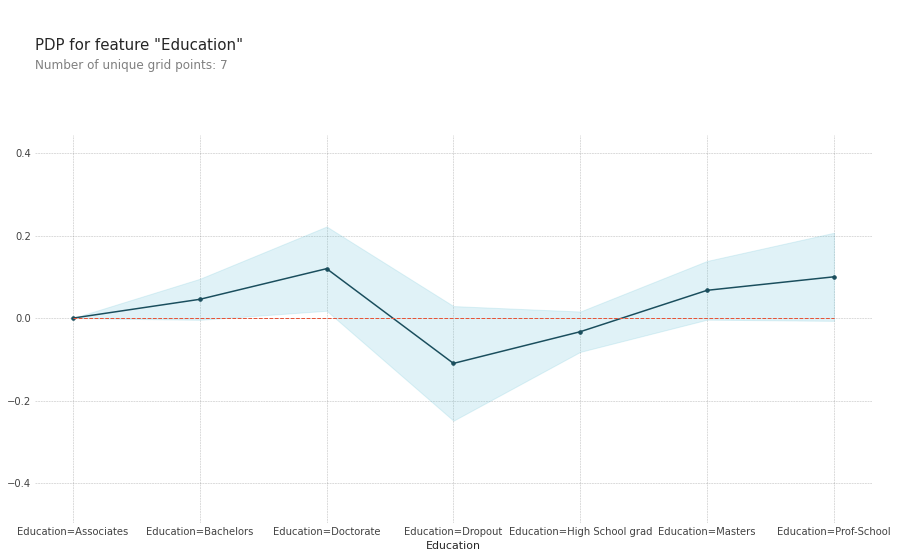

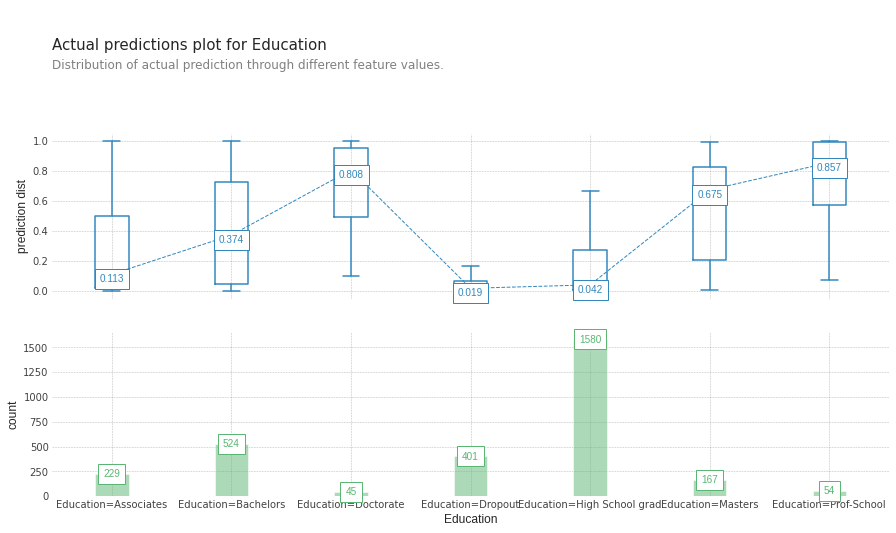

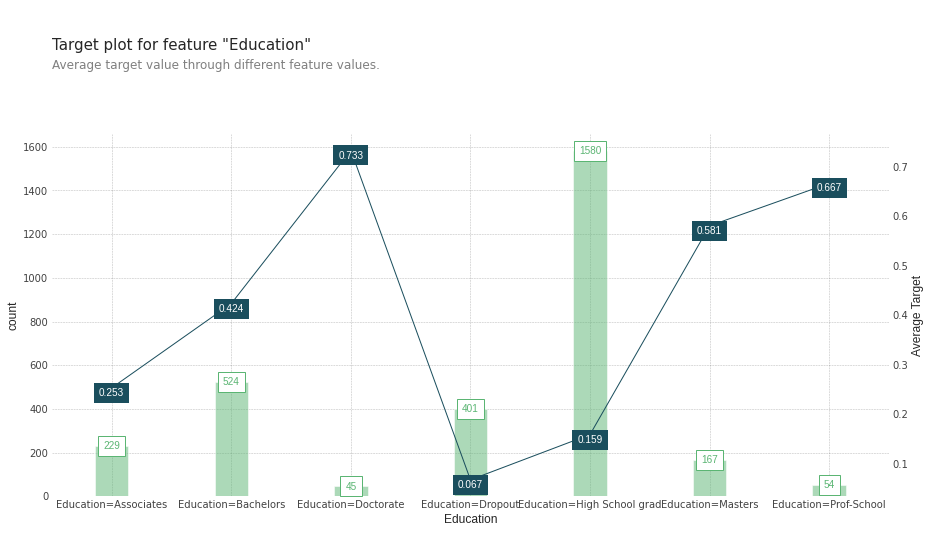

In [14]:
# One-hot encoded feature

feature_name = "Education"
feature = category_map[feature_name]

fig = pdp_plot(clf, x_sample, FEATURES, feature, feature_name)
fig, _ = actual_plot(clf, x_sample, feature, feature_name)
fig, _ = target_plot(sample, feature, feature_name, TARGET)

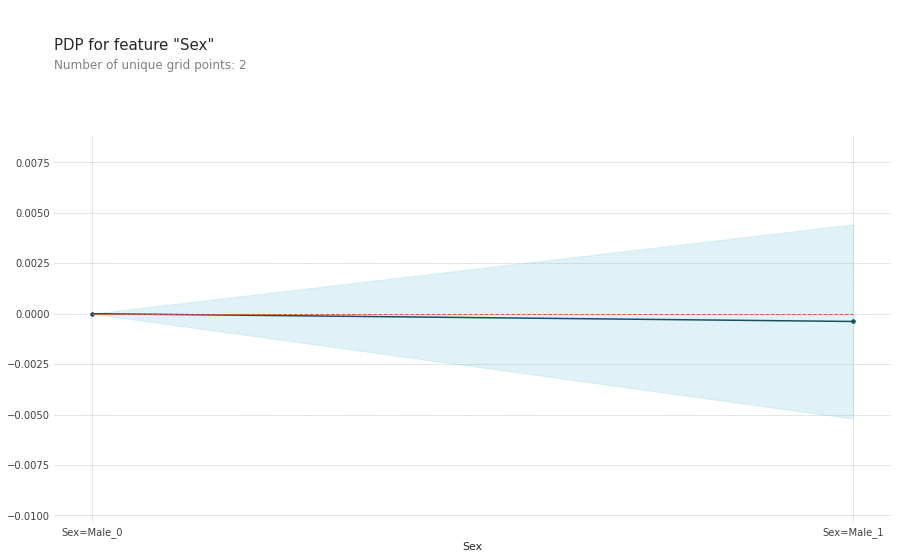

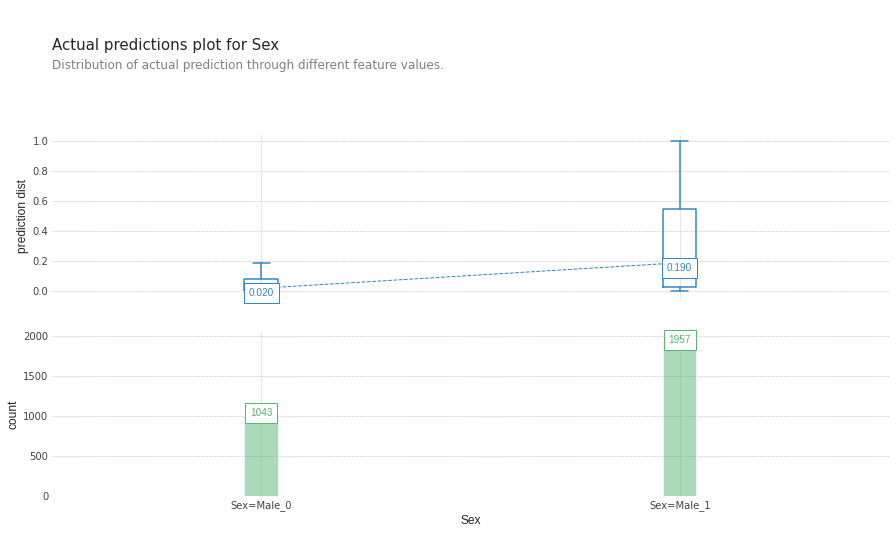

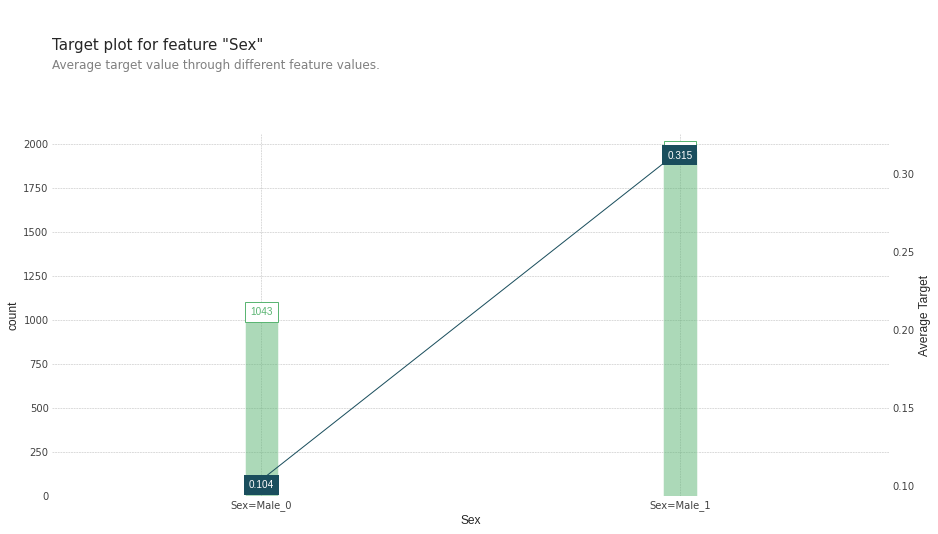

In [15]:
# Flag feature

feature_name = "Sex"
feature = "Sex=Male"

fig = pdp_plot(clf, x_sample, FEATURES, feature, feature_name)
fig, _ = actual_plot(clf, x_sample, feature, feature_name, show_percentile=True)
fig, _ = target_plot(sample, feature, feature_name, TARGET)

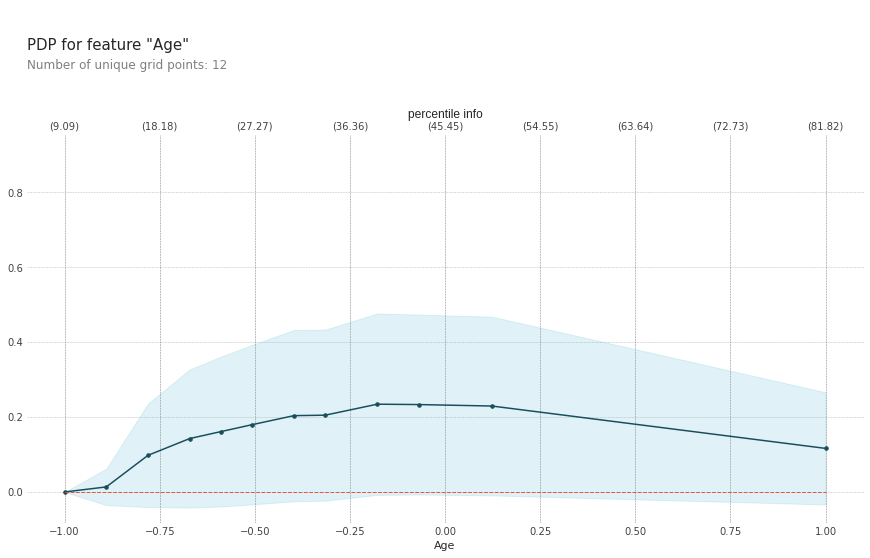

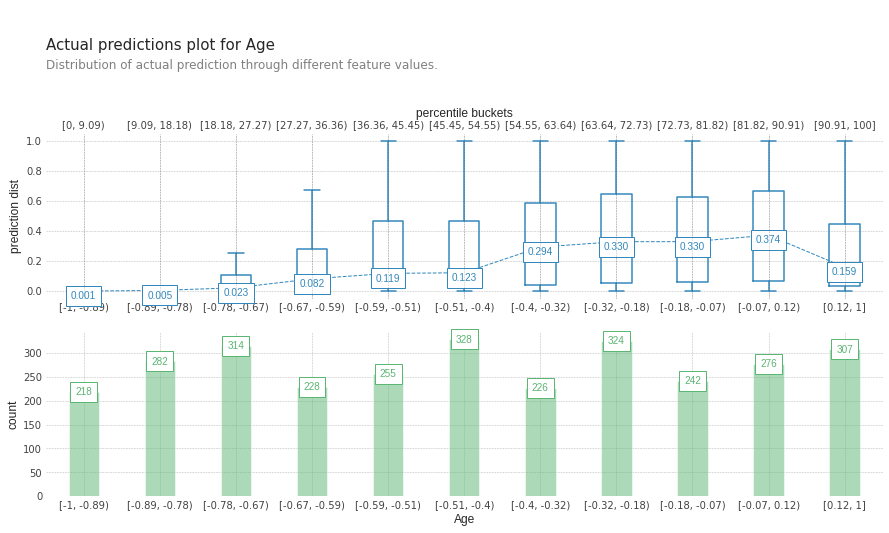

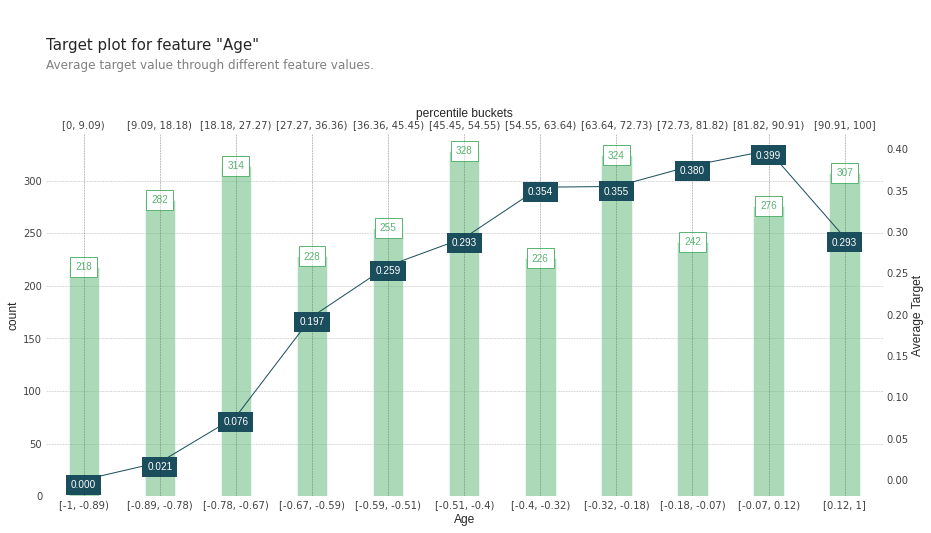

In [16]:
# Continuous feature

feature_name = "Age"
feature = feature_name

fig = pdp_plot(clf, x_sample, FEATURES, feature, feature_name, num_grid_points=12, show_percentile=True)
fig, _ = actual_plot(clf, x_sample, feature, feature_name, num_grid_points=12, show_percentile=True)
fig, _ = target_plot(sample, feature, feature_name, TARGET, num_grid_points=12, show_percentile=True)

### 2D Partial Dependence Plots

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


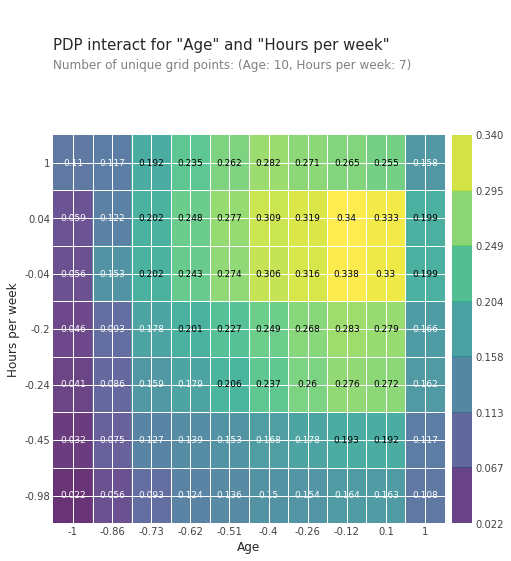

In [17]:
feature1 = 'Age'
feature2 = 'Hours per week'

fig = pdp_interact_plot(clf, x_sample, FEATURES, feature1, feature2)

In [18]:
from pdpbox import info_plots

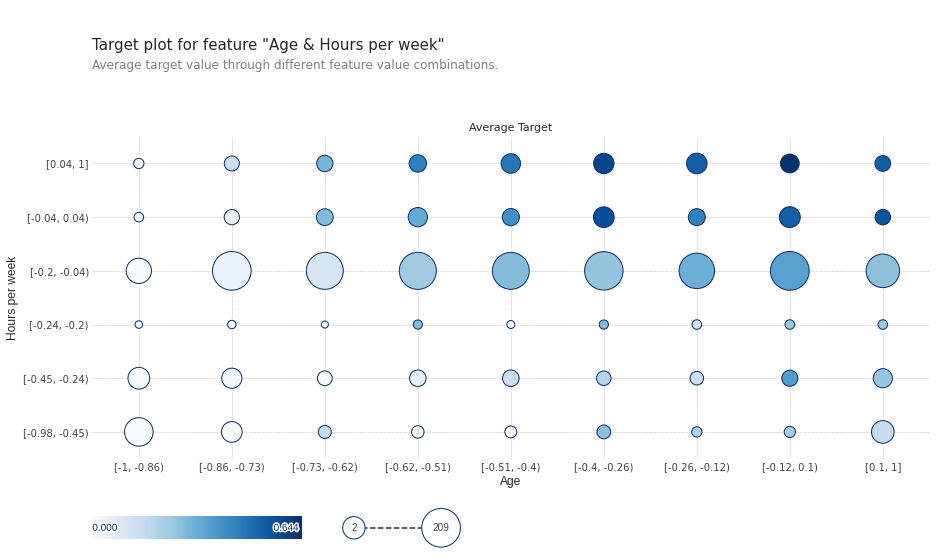

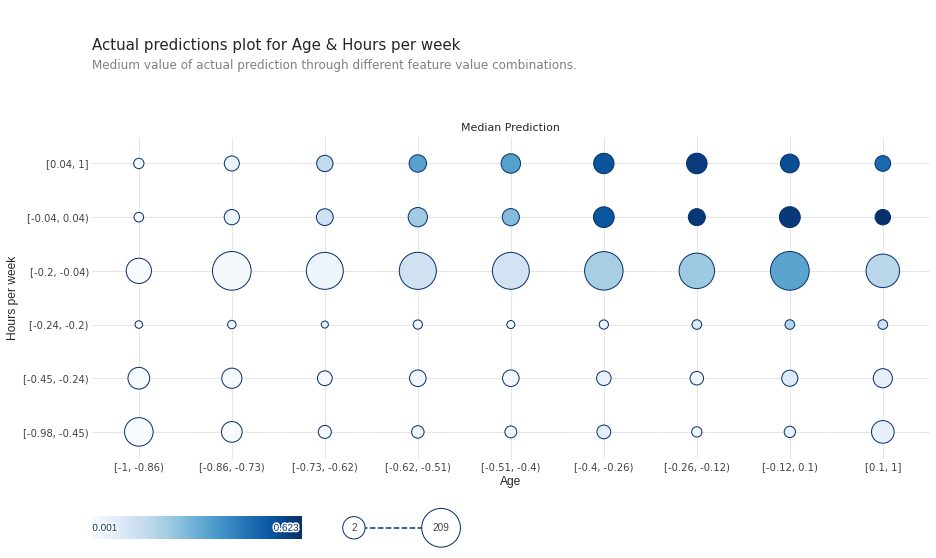

In [19]:
fig, axes, summary_df = info_plots.target_plot_interact(
    sample, [feature1, feature2], [feature1, feature2], TARGET)

fig, axes, summary_df = info_plots.actual_plot_interact(
    clf, x_sample, [feature1, feature2], [feature1, feature2])

# SHAP

The SHAP package has explainers for every type of model:
- `shap.TreeExplainer` works with tree-based models (XGBoost/LightGBM/CatBoost/scikit-learn/pyspark models)
- `shap.DeepExplainer` works with Deep Learning models (TensorFlow/Keras models) 
- `shap.KernelExplainer` works with all models, though it is slower than other explainers and it provides only approximation rather than exact Shapley values.

In [20]:
# LightGBM is used in our toy example, hence TreeExplainer
explainer = shap.TreeExplainer(clf)

# Calculate Shap values
shap_values = explainer.shap_values(x_sample)[1]

### Explain individual instance

In [21]:
row_to_show = 2185
data_for_prediction = x_sample.iloc[row_to_show]  # use 1 row of data here. Could use multiple rows if desired

In [22]:
# Predicted probabilities
clf.predict_proba(data_for_prediction.values.reshape(1, -1))[0]

array([0.9530876, 0.0469124])

In [23]:
# Visualize the SHAP values using force_plot
shap.force_plot(explainer.expected_value[1], shap_values[row_to_show], data_for_prediction, link='logit')

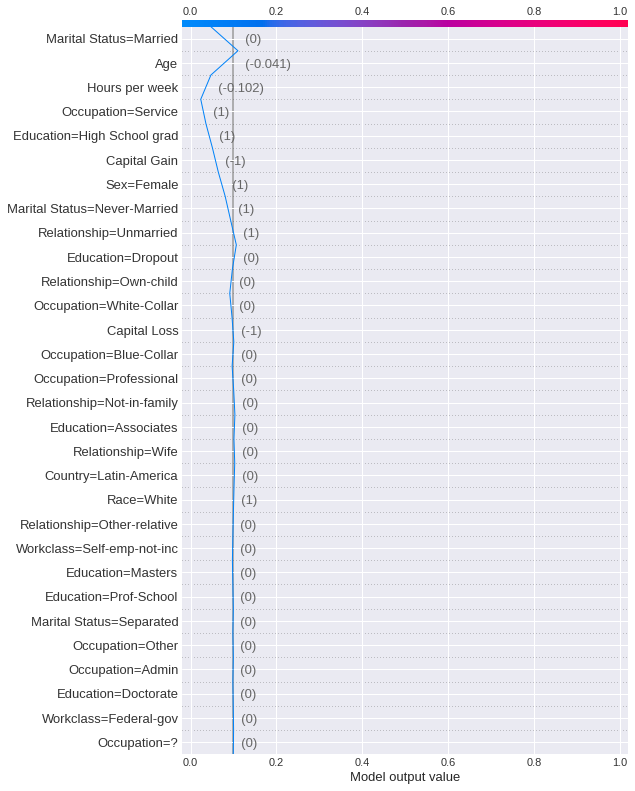

In [24]:
# Visualize the SHAP values using decision_plot
shap.decision_plot(explainer.expected_value[1], shap_values[row_to_show], data_for_prediction, link='logit',
                   feature_display_range=slice(None, -31, -1))

In [25]:
# use Kernel SHAP to explain test set predictions. The results should be similar as above.
k_explainer = shap.KernelExplainer(clf.predict_proba, x_sample)
k_shap_values = k_explainer.shap_values(data_for_prediction)[1]

Using 3000 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [26]:
# Visualize the SHAP values. Note that the values are probabilities
shap.force_plot(k_explainer.expected_value[1], k_shap_values, data_for_prediction)

### Summary plot

In [27]:
help(shap.summary_plot)

Help on function summary_plot in module shap.plots.summary:

summary_plot(shap_values, features=None, feature_names=None, max_display=None, plot_type=None, color=None, axis_color='#333333', title=None, alpha=1, show=True, sort=True, color_bar=True, plot_size='auto', layered_violin_max_num_bins=20, class_names=None, class_inds=None, color_bar_label='Feature value', auto_size_plot=None)
    Create a SHAP summary plot, colored by feature values when they are provided.
    
    Parameters
    ----------
    shap_values : numpy.array
        For single output explanations this is a matrix of SHAP values (# samples x # features).
        For multi-output explanations this is a list of such matrices of SHAP values.
    
    features : numpy.array or pandas.DataFrame or list
        Matrix of feature values (# samples x # features) or a feature_names list as shorthand
    
    feature_names : list
        Names of the features (length # features)
    
    max_display : int
        How many top

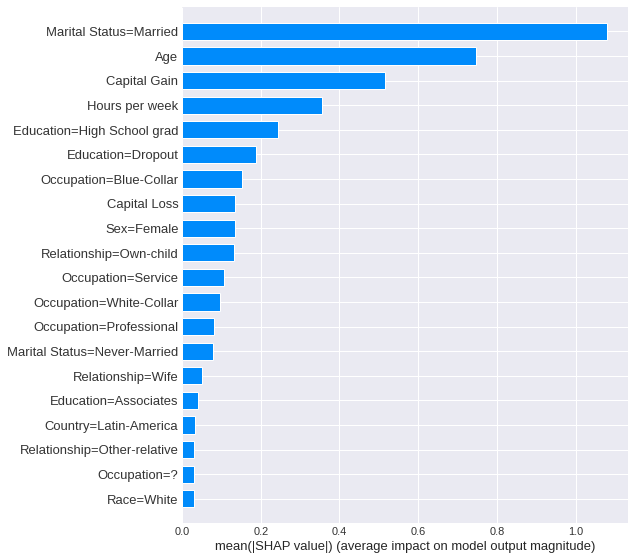

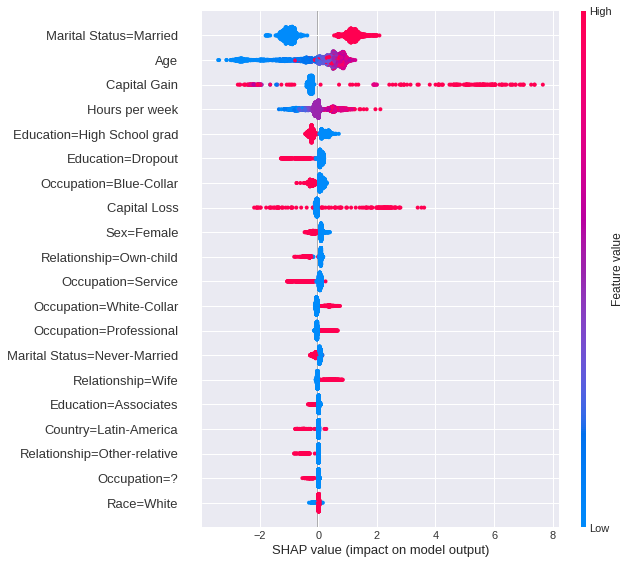

In [28]:
# summarize the effects of all features
shap.summary_plot(shap_values, plot_type="bar", feature_names=FEATURES)
shap.summary_plot(shap_values, x_sample, feature_names=FEATURES)

### SHAP Dependence Contribution Plots

In [29]:
help(shap.dependence_plot)

Help on function dependence_plot in module shap.plots.dependence:

dependence_plot(ind, shap_values, features, feature_names=None, display_features=None, interaction_index='auto', color='#1E88E5', axis_color='#333333', cmap=None, dot_size=16, x_jitter=0, alpha=1, title=None, xmin=None, xmax=None, ax=None, show=True)
    Create a SHAP dependence plot, colored by an interaction feature.
    
    Plots the value of the feature on the x-axis and the SHAP value of the same feature
    on the y-axis. This shows how the model depends on the given feature, and is like a
    richer extenstion of the classical parital dependence plots. Vertical dispersion of the
    data points represents interaction effects. Grey ticks along the y-axis are data
    points where the feature's value was NaN.
    
    
    Parameters
    ----------
    ind : int or string
        If this is an int it is the index of the feature to plot. If this is a string it is
        either the name of the feature to plot, or i

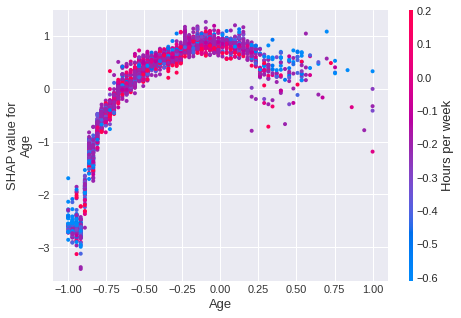

In [30]:
feature = "Age"
interaction_feature = "Hours per week"
shap.dependence_plot(feature, shap_values, x_sample, interaction_index=interaction_feature)

If you don't supply an argument for `interaction_index`, SHAP uses some logic to pick one that may be interesting.

# Entry point for fairness metrics

- In this toy example, the favourable label is '>50K' which corresponds to 1
- Suppose that race is the protected column, and that race=white is the privileged group and the rest forms the unprivileged group. 

**Ensure that the data is not one-hot encoded, so that the helpers can find the privileged and unprivileged groups from the data provided by you.**

In [31]:
from toolkit import prepare_dataset, get_fairness

In [35]:
BIAS_INFO = {
    'favorable_label': 1,
    'unfavorable_label': 0,
    'protected_columns': ['Race=Amer-Indian-Eskimo', 'Race=Asian-Pac-Islander',
                          'Race=Black', 'Race=Other', 'Race=White']
}

# 
PRIVILEGED_INFO = {
    'unprivileged_groups': [{'Race=White': 0}],
    'privileged_groups': [{'Race=White': 1}]
}

In [44]:
y_val_prob = clf.predict_proba(x_val)[:, 1]
y_val_pred = (y_val_prob > 0.5).astype(int)
compute_log_metrics(y_val, y_val_prob)

Accuracy = 0.877902
ROC AUC = 0.925541
Average precision = 0.811521


In [45]:
# Prepare val dataset

grdtruth_val = prepare_dataset(x_val, y_val, **BIAS_INFO, **PRIVILEGED_INFO)
predicted_val = prepare_dataset(x_val, y_val_pred, **BIAS_INFO, **PRIVILEGED_INFO)

Fairness is when deviation < 0.2


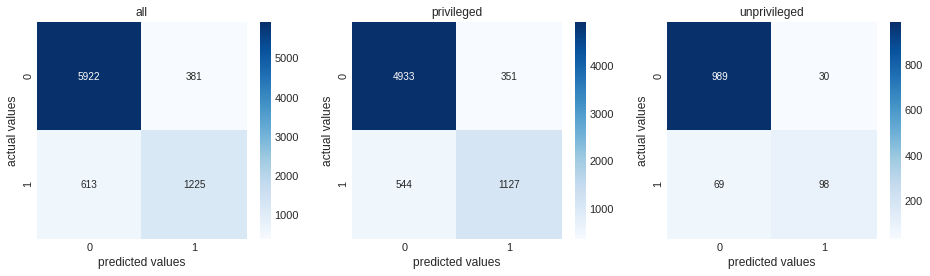

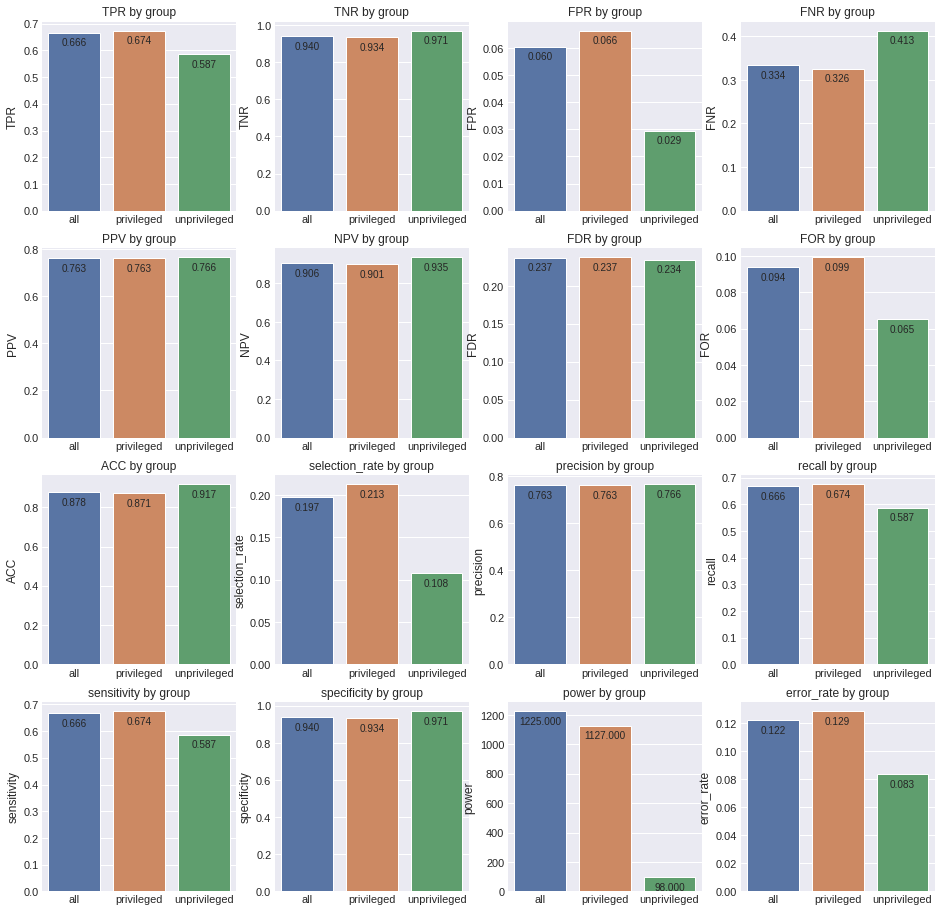

In [46]:
# Compute fairness
fmetrics_pre, fmetrics2_pre, fig_confmats, fig_perfs = get_fairness(
    grdtruth_val, predicted_val, **PRIVILEGED_INFO)

In [47]:
fmetrics_pre.style.applymap(color_red, subset=['Deviation'])

,Metric name,Definition,Criterion,Ratio,Deviation
0,Statistical parity,equal proportion of predicted positives,Independence,0.507865,-0.492135
1,Equal opportunity,equal FNR,Separation,1.269142,0.269142
2,Predictive parity,equal PPV,Sufficiency,1.004076,0.004076


In [48]:
fmetrics2_pre.style.applymap(color_red, subset=['Deviation'])

,Metric name,Definition,Criterion,Ratio,Deviation
0,Predictive equality,equal FPR,Separation,0.443203,-0.556797
1,Equalized odd,equal TPR and equal FPR,Separation,0.831811,-0.168189
2,Conditional use accuracy equality,equal PPV and equal NPV,Sufficiency,1.022376,0.022376


# Debiasing: calibrated equal odds

We demonstrate a form of debiasing here using calibrated equal odds.
- Optimizes for TPR/FPR difference and improves calibration.
- Requires only model predictions as input, so no need to retrain anything
- But no option to tweak fairness-accuracy tradeoff

In [49]:
from aif360.algorithms.postprocessing import CalibratedEqOddsPostprocessing

In [52]:
# Prepare train dataset
y_train_prob = clf.predict_proba(x_train)[:, 1]
y_train_pred = (y_train_prob > 0.5).astype(int)

grdtruth_train = prepare_dataset(x_train, y_train, **BIAS_INFO, **PRIVILEGED_INFO)
predicted_train = prepare_dataset(x_train, y_train_pred, **BIAS_INFO, **PRIVILEGED_INFO)

In [53]:
calibrator = CalibratedEqOddsPostprocessing(**PRIVILEGED_INFO, seed=0)

calibrator.fit(grdtruth_train, predicted_train)

In [54]:
# Predict using calibrator
adj_predicted_val = calibrator.predict(predicted_val)

# Compute accuracy after debiasing
print("Accuracy = {:.6f}".format(metrics.accuracy_score(y_val, adj_predicted_val.labels.squeeze())))

Accuracy = 0.861319


Fairness is when deviation < 0.2


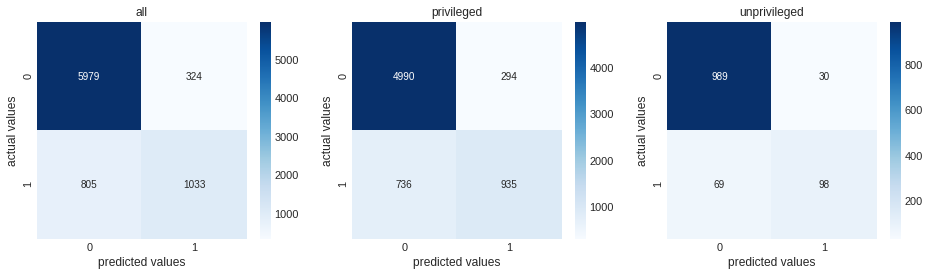

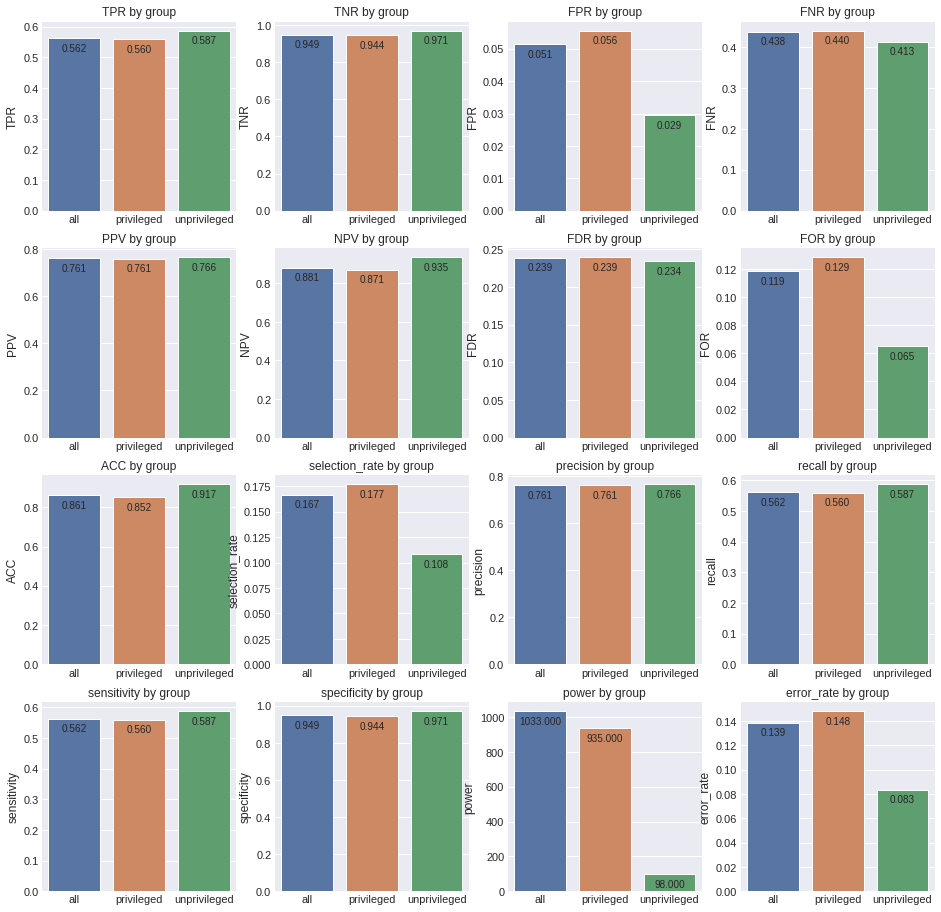

In [55]:
# Compute fairness
fmetrics_adj, fmetrics2_adj, fig_confmats_adj, fig_perfs_adj = get_fairness(
    grdtruth_val, adj_predicted_val, **PRIVILEGED_INFO)

In [56]:
fmetrics_adj.style.applymap(color_red, subset=['Deviation'])

,Metric name,Definition,Criterion,Ratio,Deviation
0,Statistical parity,equal proportion of predicted positives,Independence,0.610760,-0.389240
1,Equal opportunity,equal FNR,Separation,0.938061,-0.061939
2,Predictive parity,equal PPV,Sufficiency,1.006367,0.006367


In [57]:
fmetrics2_adj.style.applymap(color_red, subset=['Deviation'])

,Metric name,Definition,Criterion,Ratio,Deviation
0,Predictive equality,equal FPR,Separation,0.529130,-0.470870
1,Equalized odd,equal TPR and equal FPR,Separation,1.001759,0.001759
2,Conditional use accuracy equality,equal PPV and equal NPV,Sufficiency,1.041760,0.041760


# Debiasing: adversarial debiasing

In [58]:
import tensorflow as tf
from aif360.algorithms.inprocessing import AdversarialDebiasing

In [ ]:
# ['Race=Amer-Indian-Eskimo', 'Race=Asian-Pac-Islander', 'Race=Black', 'Race=Other', 'Race=White']

def collapse_group(x):
    if x == 4:
        return 1
    return 0


train_ = raw_x_train.copy()
val_ = raw_x_val.copy()

train_['Race'] = train_['Race'].apply(collapse_group)
val_['Race'] = val_['Race'].apply(collapse_group)


BIAS_INFO = {
    'favorable_label': 1,
    'unfavorable_label': 0,
    'protected_columns': ['Race']
}

PRIVILEGED_INFO = {
    'unprivileged_groups': [{'Race': 0}],
    'privileged_groups': [{'Race': 1}]
}

In [ ]:
# Prepare train dataset
grdtruth_train = prepare_dataset(train_, y_train, **BIAS_INFO, **PRIVILEGED_INFO)
grdtruth_val = prepare_dataset(val_, y_val, **BIAS_INFO, **PRIVILEGED_INFO)

In [ ]:
model_params = {
    'classifier_num_hidden_units':200, 
    'num_epochs':20,
    'batch_size':128,
    'adversary_loss_weight':0.1,
    'debias':True,
    'seed':1234,
}

with tf.Session() as sess:
    clf = AdversarialDebiasing(scope_name='debiased_classifier', sess=sess, **PRIVILEGED_INFO, **model_params)
    clf.fit(grdtruth_train)
    
    # Predict
    adj_val = clf.predict(grdtruth_val)

In [ ]:
# Compute accuracy after debiasing
print("Accuracy = {:.6f}".format(metrics.accuracy_score(y_val, adj_val.labels.squeeze())))

In [ ]:
# Compute fairness
fmetrics_adj, fmetrics2_adj, fig_confmats_adj, fig_perfs_adj = get_fairness(
    grdtruth_val, adj_val, **PRIVILEGED_INFO)

In [ ]:
fmetrics_adj.style.applymap(color_red, subset=['Deviation'])

In [ ]:
fmetrics2_adj.style.applymap(color_red, subset=['Deviation'])

In [ ]:
sess.close()
tf.reset_default_graph()